# Part1: Feature Extraction

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are 2 main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

**Transfer learning often allows you to get great results with less data.**

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)

## Download and become one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-09-23 10:53:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.219.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   176MB/s    in 0.9s    

2021-09-23 10:53:29 (176 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through 10 percent data directory
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print("There are " + str(len(dirnames)) + " directories and " + str(len(filenames)) + " images in " + dirpath)

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 director

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator`class to load in our images in batches

In [ ]:
# Setup the inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.0,)
test_datagen = ImageDataGenerator(rescale=1/255.0)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

- **Experiment tracking with TensorBoard** - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
- **Model checkpointing** - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
- **Early stopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

**The TensorBoard callback**'s main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

> 🔑 **Note:** We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print("Saving TensorBoard log files to: " + log_dir)
  return tensorboard_callback

🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option

## Creating models using TensorFlow Hub

In the past, we've used TensorFlow to create our own models layer by layer from scratch

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

We're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

In [ ]:
# Let's compare the following 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned pattern
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE + (3,)) 
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Those non-trainable params are the frozen ones.

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210923-105345
Epoch 1/5
24/24 [==============================] - 60s 1s/step - loss: 1.8823 - accuracy: 0.3867 - val_loss: 1.2154 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - 22s 924ms/step - loss: 0.9065 - accuracy: 0.7413 - val_loss: 0.9022 - val_accuracy: 0.6996
Epoch 3/5
24/24 [==============================] - 21s 920ms/step - loss: 0.6285 - accuracy: 0.8307 - val_loss: 0.7668 - val_accuracy: 0.7476
Epoch 4/5
24/24 [==============================] - 21s 917ms/step - loss: 0.4798 - accuracy: 0.8787 - val_loss: 0.7349 - val_accuracy: 0.7524
Epoch 5/5
24/24 [==============================] - 21s 919ms/step - loss: 0.3936 - accuracy: 0.9133 - val_loss: 0.6942 - val_accuracy: 0.7648


Our transfer learning feature extractor model out performed ALL of the prevous models we built by hand... and in a quicker training time AND with only 10% of the training images 

In [ ]:
# Let's create a function to plot our loss curves
# Tidbit: You could put a function like this into a script called "helper.py" and import it when you need it
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object
  
  Returns:
    Plots of training/validation loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

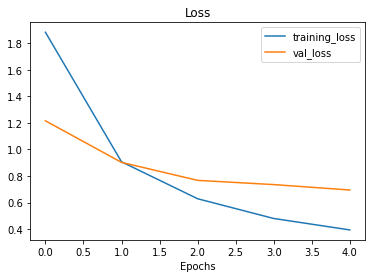

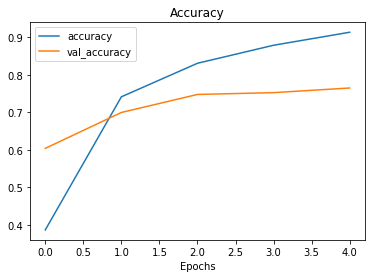

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 extractor model
efficientnet_model = create_model(efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="Adam",
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                                epochs=5,
                                                steps_per_epoch=len(train_data_10_percent),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[create_tensorboard_callback("tensorflow_hub",
                                                                                       "efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210923-105628
Epoch 1/5
24/24 [==============================] - 33s 981ms/step - loss: 1.8858 - accuracy: 0.4427 - val_loss: 1.3213 - val_accuracy: 0.7144
Epoch 2/5
24/24 [==============================] - 19s 797ms/step - loss: 1.0753 - accuracy: 0.7667 - val_loss: 0.8770 - val_accuracy: 0.8148
Epoch 3/5
24/24 [==============================] - 18s 791ms/step - loss: 0.7674 - accuracy: 0.8360 - val_loss: 0.7067 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 18s 793ms/step - loss: 0.6132 - accuracy: 0.8627 - val_loss: 0.6161 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 19s 796ms/step - loss: 0.5195 - accuracy: 0.8867 - val_loss: 0.5597 - val_accuracy: 0.8620


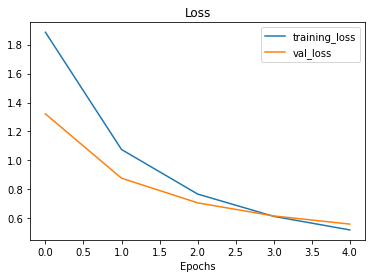

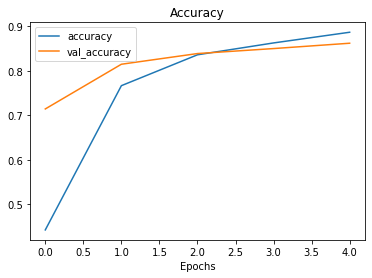

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
efficientnet_model.layers

In [ ]:
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

1. **transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes. 

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class). 

    * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. 

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. 

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

## Comparing our models using TensorBoard

> 🔑 **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), your experiments are public. So if you're running private experiments, don't upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2"  \
  --description "Comparing two different TF Hub feature extraction model architecture using 10% of the training data" \
  --one_shot

Where:
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is a brief description of the experiment
* `--one_shot` exits the TensorBoard uploader once uploading is finished

Running the `tensorboard dev upload` command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

> Above cell will give us a link to get our private code. Do not share your code with anyone else. I'm deleting the above cell's output due to the privacy and safety of my account

Our TensorBoard experiments are uploaded publicly here: https://tensorboard.dev/experiment/r2rvYiDKRuOfkuNSWbu7Pw/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-09-23 11:42:30.219305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:42:30.228700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:42:30.229241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/r2rvYiDKRuOfkuNSWbu7Pw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   r2rvYiDKRuOfkuNSWbu7Pw
	Created              2021-09-23 11:36:38 (5 minutes ago)
	Upd

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id ulvY4GVkSburYy81he3zdQ

2021-09-23 11:43:38.356580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:43:38.364974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:43:38.365483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Deleted experiment ulvY4GVkSburYy81he3zdQ.


In [ ]:
!tensorboard dev list

2021-09-23 11:43:51.105391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:43:51.114445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:43:51.114887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/r2rvYiDKRuOfkuNSWbu7Pw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   r2rvYiDKRuOfkuNSWbu7Pw
	Created              2021-09-23 11:36:38 (7 minutes ago)
	Upd